# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:**Taylor Galdi

*Semester:* Fall 2024

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%pip install keras
%pip install tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


2024-12-08 14:05:33.163214: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

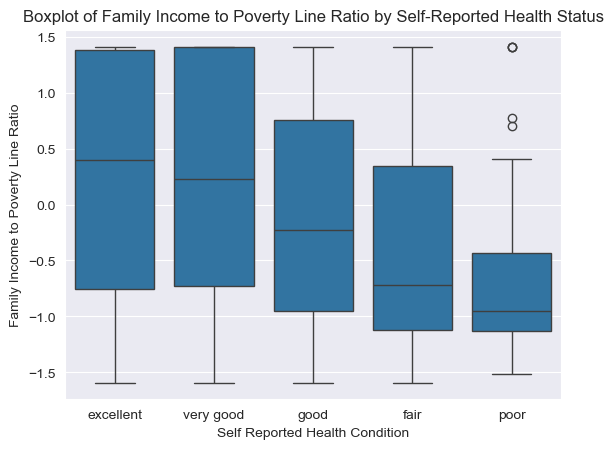

In [3]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

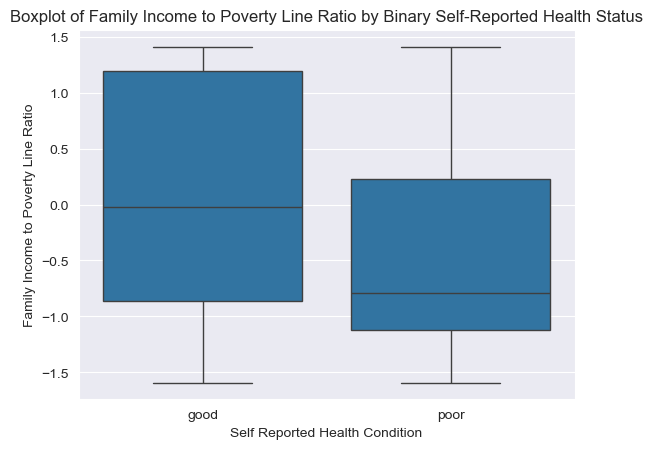

In [4]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

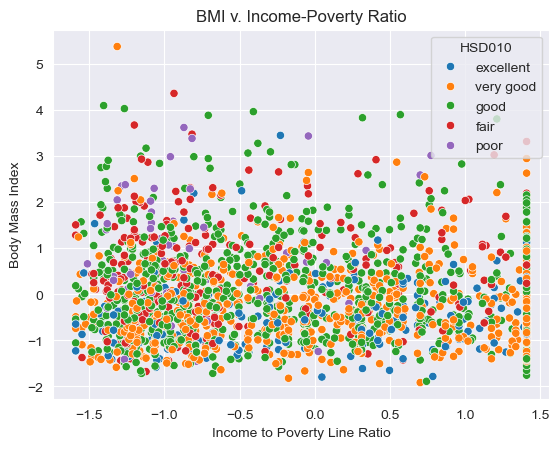

In [5]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [6]:
nhanestarget = nhanes_scaled
nhanestarget = nhanestarget.reset_index()
print(nhanestarget.head())

    SEQN  DR1DRSTZ  DR1EXMER  DRABF    DRDINT   DR1DBIH    DR1DAY   DR1LANG  \
0  73568       0.0  2.034312    0.0  0.324834 -0.393906  1.085853 -0.194202   
1  73576       0.0  0.261930    0.0 -3.078499  0.568251  0.634362 -0.194202   
2  73579       0.0  0.728346    0.0  0.324834  1.530407 -1.623092 -0.194202   
3  73581       0.0 -0.857470    0.0  0.324834  0.480782  1.085853 -0.194202   
4  73584       0.0  0.495138    0.0  0.324834  0.305844 -1.623092 -0.194202   

   DR1MNRSP  DR1HELPD  ...    OHQ845   PAAQUEX    SMQ860  SMQ870    SMQ872  \
0 -0.057306  0.128246  ... -0.646584 -0.484200  1.125008     0.0 -2.081666   
1 -0.057306  0.128246  ... -1.539259 -0.484200  1.125008     0.0 -2.081666   
2 -0.057306  0.128246  ... -1.539259  2.065262 -0.888883     0.0  0.480384   
3 -0.057306  0.128246  ... -0.646584 -0.484200  1.125008     0.0  0.480384   
4 -0.057306  0.128246  ...  0.246091  2.065262  1.125008     0.0  0.480384   

     SMQ874    SMQ878  SMAQUEX.x     HSD010  HSD010_bina

In [7]:
print(nhanes_scaled.head())

       DR1DRSTZ  DR1EXMER  DRABF    DRDINT   DR1DBIH    DR1DAY   DR1LANG  \
SEQN                                                                       
73568       0.0  2.034312    0.0  0.324834 -0.393906  1.085853 -0.194202   
73576       0.0  0.261930    0.0 -3.078499  0.568251  0.634362 -0.194202   
73579       0.0  0.728346    0.0  0.324834  1.530407 -1.623092 -0.194202   
73581       0.0 -0.857470    0.0  0.324834  0.480782  1.085853 -0.194202   
73584       0.0  0.495138    0.0  0.324834  0.305844 -1.623092 -0.194202   

       DR1MNRSP  DR1HELPD   DBQ095Z  ...    OHQ845   PAAQUEX    SMQ860  \
SEQN                                 ...                                 
73568 -0.057306  0.128246 -0.189513  ... -0.646584 -0.484200  1.125008   
73576 -0.057306  0.128246  0.080373  ... -1.539259 -0.484200  1.125008   
73579 -0.057306  0.128246 -0.189513  ... -1.539259  2.065262 -0.888883   
73581 -0.057306  0.128246  0.080373  ... -0.646584 -0.484200  1.125008   
73584 -0.057306  0.1282

In [8]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)
nhanes_scaled = nhanes_scaled.reset_index()
print(nhanes_scaled.head())

    SEQN  DR1DRSTZ  DR1EXMER  DRABF    DRDINT   DR1DBIH    DR1DAY   DR1LANG  \
0  73568       0.0  2.034312    0.0  0.324834 -0.393906  1.085853 -0.194202   
1  73576       0.0  0.261930    0.0 -3.078499  0.568251  0.634362 -0.194202   
2  73579       0.0  0.728346    0.0  0.324834  1.530407 -1.623092 -0.194202   
3  73581       0.0 -0.857470    0.0  0.324834  0.480782  1.085853 -0.194202   
4  73584       0.0  0.495138    0.0  0.324834  0.305844 -1.623092 -0.194202   

   DR1MNRSP  DR1HELPD  ...    OHQ033    OHQ770    OHQ845   PAAQUEX    SMQ860  \
0 -0.057306  0.128246  ... -0.680203  0.383802 -0.646584 -0.484200  1.125008   
1 -0.057306  0.128246  ... -0.680203  0.383802 -1.539259 -0.484200  1.125008   
2 -0.057306  0.128246  ... -0.680203  0.383802 -1.539259  2.065262 -0.888883   
3 -0.057306  0.128246  ... -0.680203  0.383802 -0.646584 -0.484200  1.125008   
4 -0.057306  0.128246  ... -0.680203 -2.605509  0.246091  2.065262  1.125008   

   SMQ870    SMQ872    SMQ874    SMQ878  SMA

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

In [9]:
# scale data
# ----------
X = nhanes_scaled.drop(columns=['SEQN']).values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
# apply PCA
# ----------
pca_all = PCA() # notice we do not specify the number of components if we want to keep them all
principalComponents_nhanes = pca_all.fit_transform(X)

### Scree Plot(s) of Explained Variance

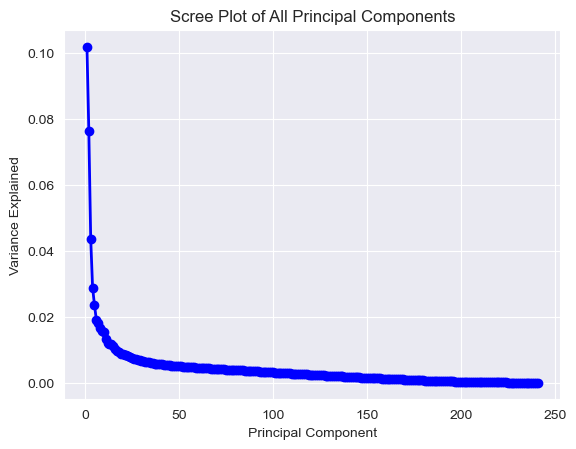

In [11]:
# create scree plot from PCA fit
# ----------
PC_values = np.arange(pca_all.n_components_) + 1
plt.plot(PC_values, pca_all.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot of All Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

Obviously, this is far too many components. There is an elbow here somewhere between 0-50, so let's just plot the first 20 components to see if we can see where there is a reasonable trade off between number of components and amount of variation explained. 

In [12]:
# Fit PCA model for less components 
pca = PCA(n_components=20)
pca.fit(X)

PCA(n_components=20)

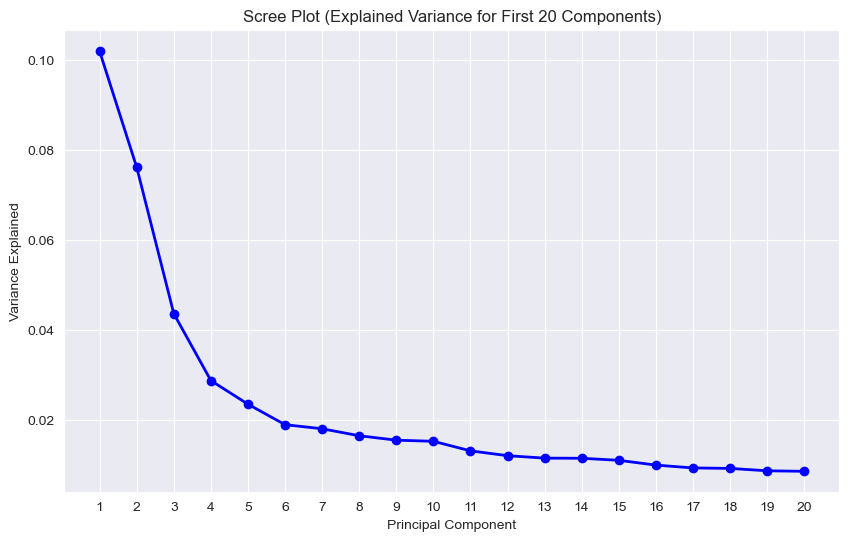

In [13]:
# PC values are the principal component indices (1, 2, 3,...)
PC_values = np.arange(pca.n_components_) + 1

# Create scree plot
plt.figure(figsize=(10, 6))
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')

# Title and labels
plt.title('Scree Plot (Explained Variance for First 20 Components)')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.xticks(PC_values)
plt.grid(True)

### Barplot of Components

/var/folders/51/tvqz_23j083bt8bcsjfhnyk40000gn/T/ipykernel_96914/3564382604.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(range(1, len(explained_variance_ratio) + 1)),


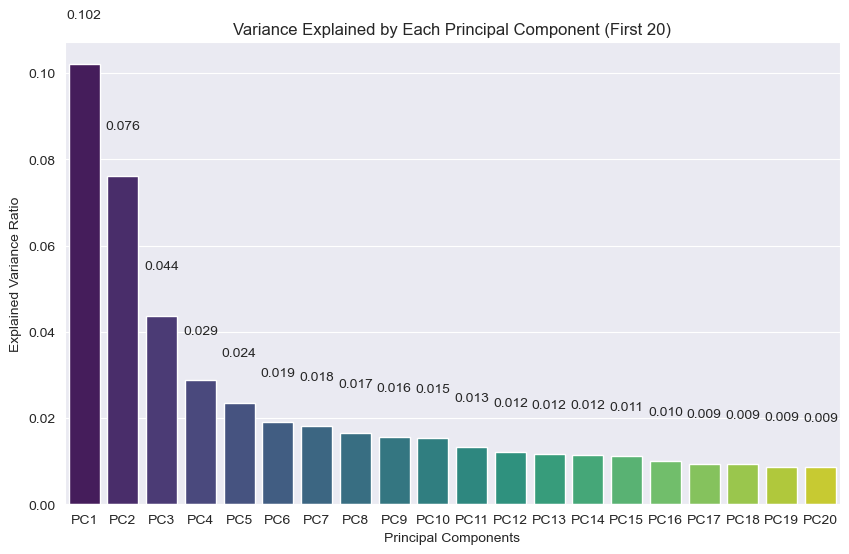

In [14]:
# Explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Create a bar plot to show the variance explained by each component
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=list(range(1, len(explained_variance_ratio) + 1)), 
                 y=explained_variance_ratio, 
                 palette='viridis')

# Add annotations for each bar with the value of explained variance
for i, v in enumerate(explained_variance_ratio):
    ax.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=10)

# Title and labels
plt.title('Variance Explained by Each Principal Component (First 20)')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(ticks=range(len(explained_variance_ratio)), labels=[f'PC{i+1}' for i in range(len(explained_variance_ratio))])
plt.grid(True, axis='y')

# Show the plot
plt.show()

### How many components will you use to fit a supervised learning model?

Based on what we are seeing here and also in the scree plot, I am going to choose 16 components. Although we could choose less (for example, it looks like even the first two componenets are explaining a fair amount of variance), as we talked about in class, when we have so many features in the data set, it probably won't hurt us too much to keep some more commponents in. Because our next step is to apply PCA for only 2 components, I will apply the PCA with 16 components after the following section, before the clustering.

### 2D Scatterplot of the first two components

In [17]:
# apply PCA
# ----------
pca2 = PCA(n_components=2)
pca2_result = pca2.fit_transform(X)

In [18]:
# convert into a dataframe
# ----------
pca2_df = pd.DataFrame(data=pca2_result, 
                       columns=['principal component 1', 'principal component 2'])

# Add the SEQN column back from the original nhanes_scaled Data Frame so we can merge
pca2_df['SEQN'] = nhanes_scaled['SEQN'].values

# Now pca2_df should have the SEQN (index) column
print(pca2_df.head())

   principal component 1  principal component 2   SEQN
0               9.527811              -0.816223  73568
1              -5.838337              -3.692574  73576
2              -0.719454              -2.573201  73579
3               3.533628              -2.576983  73581
4              -6.872094              -4.194239  73584


In [23]:
# Merge the PCA results with the target labels to align the data
merged_df = pca2_df.merge(nhanestarget[['SEQN', 'HSD010','HSD010_binary']], on='SEQN', how='inner')

# Check the merged DataFrame
print(merged_df.head())

   principal component 1  principal component 2   SEQN     HSD010  \
0               9.527811              -0.816223  73568  excellent   
1              -5.838337              -3.692574  73576  excellent   
2              -0.719454              -2.573201  73579  very good   
3               3.533628              -2.576983  73581  very good   
4              -6.872094              -4.194239  73584       good   

  HSD010_binary  
0          good  
1          good  
2          good  
3          good  
4          good  


In [24]:
#Check the original dataframe to make sure that the SEQN aligns with the target 
print(nhanestarget.head())

    SEQN  DR1DRSTZ  DR1EXMER  DRABF    DRDINT   DR1DBIH    DR1DAY   DR1LANG  \
0  73568       0.0  2.034312    0.0  0.324834 -0.393906  1.085853 -0.194202   
1  73576       0.0  0.261930    0.0 -3.078499  0.568251  0.634362 -0.194202   
2  73579       0.0  0.728346    0.0  0.324834  1.530407 -1.623092 -0.194202   
3  73581       0.0 -0.857470    0.0  0.324834  0.480782  1.085853 -0.194202   
4  73584       0.0  0.495138    0.0  0.324834  0.305844 -1.623092 -0.194202   

   DR1MNRSP  DR1HELPD  ...    OHQ845   PAAQUEX    SMQ860  SMQ870    SMQ872  \
0 -0.057306  0.128246  ... -0.646584 -0.484200  1.125008     0.0 -2.081666   
1 -0.057306  0.128246  ... -1.539259 -0.484200  1.125008     0.0 -2.081666   
2 -0.057306  0.128246  ... -1.539259  2.065262 -0.888883     0.0  0.480384   
3 -0.057306  0.128246  ... -0.646584 -0.484200  1.125008     0.0  0.480384   
4 -0.057306  0.128246  ...  0.246091  2.065262  1.125008     0.0  0.480384   

     SMQ874    SMQ878  SMAQUEX.x     HSD010  HSD010_bina

Plotting excellent: 239 points
Plotting very good: 672 points
Plotting good: 821 points
Plotting fair: 273 points
Plotting poor: 59 points


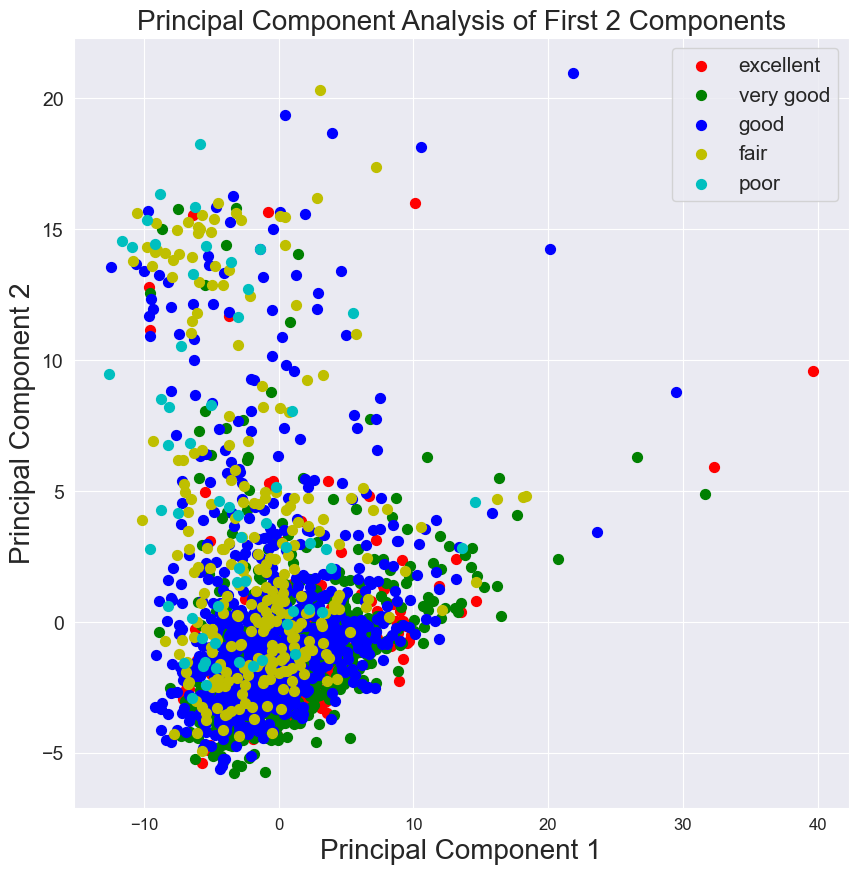

In [25]:
# Update the targets list to include all categories in the HDS10
targets = ['excellent', 'very good', 'good', 'fair', 'poor']
colors = ['r', 'g', 'b', 'y', 'c']

# Plotting
plt.figure(figsize=(10, 10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component 1', fontsize=20)
plt.ylabel('Principal Component 2', fontsize=20)
plt.title("Principal Component Analysis of First 2 Components", fontsize=20)

# Loop over targets and colors to create scatterplot
for target, color in zip(targets, colors):
    # Use the merged DataFrame to filter for the target
    indicesToKeep = merged_df['HSD010'] == target
    print(f"Plotting {target}: {sum(indicesToKeep)} points") 
    if sum(indicesToKeep) > 0:
        # Plot the points for the current category (target)
        plt.scatter(merged_df.loc[indicesToKeep, 'principal component 1'],
                    merged_df.loc[indicesToKeep, 'principal component 2'], 
                    c=color, label=target, s=50)

# Add a legend
plt.legend(targets, prop={'size': 15})
plt.show()

Okay, that's a little messy, let's look at the binary version of the target.

Plotting good: 1732 points
Plotting poor: 332 points


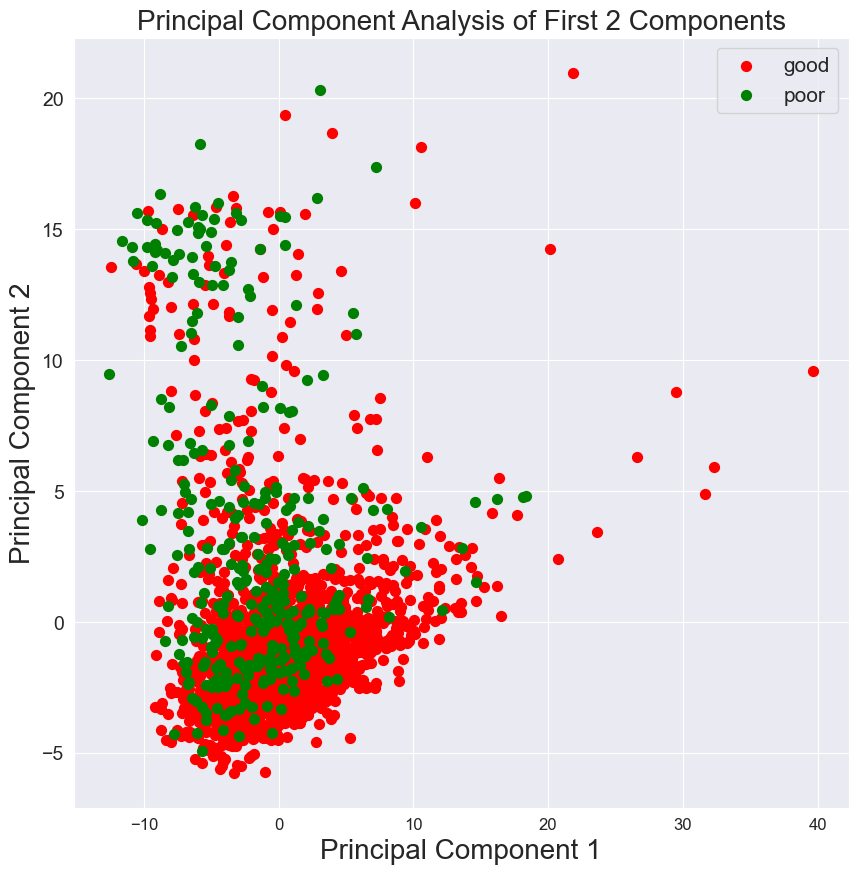

In [26]:
#Update the targets list to include all categories in the HDS10_binary
targets = [ 'good', 'poor']
colors = ['r', 'g']

# Plotting
plt.figure(figsize=(10, 10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component 1', fontsize=20)
plt.ylabel('Principal Component 2', fontsize=20)
plt.title("Principal Component Analysis of First 2 Components", fontsize=20)

# Loop over targets and colors to create scatterplot
for target, color in zip(targets, colors):
    # Use the merged DataFrame to filter for the target
    indicesToKeep = merged_df['HSD010_binary'] == target
    print(f"Plotting {target}: {sum(indicesToKeep)} points")  
    if sum(indicesToKeep) > 0:
        # Plot the points for the current category (target)
        plt.scatter(merged_df.loc[indicesToKeep, 'principal component 1'],
                    merged_df.loc[indicesToKeep, 'principal component 2'], 
                    c=color, label=target, s=50)

# Add a legend
plt.legend(targets, prop={'size': 15})
plt.show()

## PCA With Chosen Number of Components (16)

In [94]:
# apply PCA
# ----------
pca16 = PCA(n_components=16)
pca16_result = pca16.fit_transform(X)

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

In [ ]:
## Your Answer Here

### Cluster nhanes

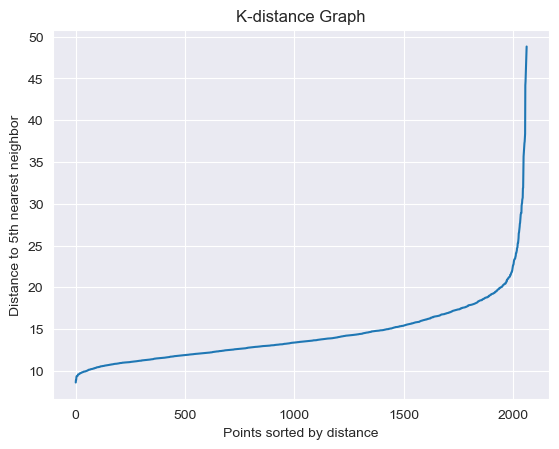

In [45]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Compute k-nearest neighbors
neighbors = NearestNeighbors(n_neighbors=5)  
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Sort distances for plotting
distances = np.sort(distances[:, -1], axis=0)

# Plot k-distance graph
plt.plot(distances)
plt.title("K-distance Graph")
plt.xlabel("Points sorted by distance")
plt.ylabel("Distance to 5th nearest neighbor")
plt.show()

In [88]:
# load library
# ----------
from sklearn.cluster import DBSCAN

# define model object
# ----------
dbscan = DBSCAN(eps=20, min_samples=5)

# fit model to data 
# ----------
dbscan.fit(X);

In [89]:
# get fitted labels for each data point 
labels = dbscan.labels_
labels

array([0, 0, 0, ..., 0, 0, 0])

In [90]:
# identify number of labels and their unique score
print(len(set(labels)))
print(np.unique(labels))

4
[-1  0  1  2]


In [91]:
# get inferred clusters 
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) # outliers will have different values
n_clusters_ 

3

In [92]:
print(X.shape)

(2064, 241)


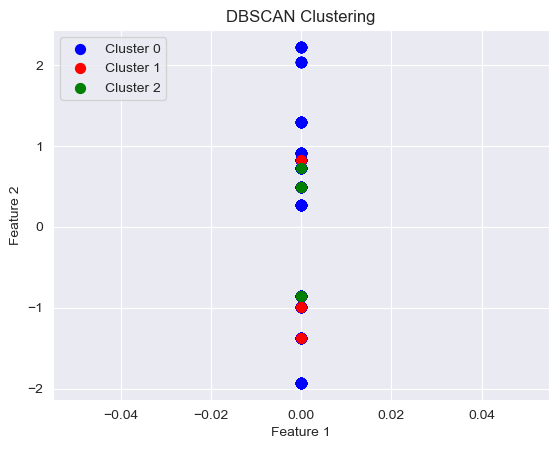

In [93]:
# split data into those for each cluster 
# ----------
zero = np.array([point for label, point in zip(dbscan.labels_, X) if label == 0])
one = np.array([point for label, point in zip(dbscan.labels_, X) if label == 1])
two = np.array([point for label, point in zip(dbscan.labels_, X) if label == 2])


# plot 
# ----------

# figure settings
fig = plt.figure()
ax1 = fig.add_subplot(111)

#plot the data with cluster assignment as the color 
ax1.scatter(zero[:, 0], zero[:, 1], s=50, c='b', label='Cluster 0')  
ax1.scatter(one[:, 0], one[:, 1], s=50, c='r', label='Cluster 1')   
ax1.scatter(two[:, 0], two[:, 1], s=50, c='g', label='Cluster 2')   

# add legend
plt.legend(loc='upper left')

# show the plot
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('DBSCAN Clustering')
plt.show()

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

In [ ]:
## Your Answer Here

## Your Answer Here

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

Unique labels: [-1]
Unique labels: [-1]


## Your Answer Here

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [ ]:
# partition data
# -----------
y = ... # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
X = ... # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [ ]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical

num_classes = ...
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(..., ...)
y_test = keras.utils.to_categorical(..., ...)
num_classes = y_test.shape[1]

In [ ]:
# create neural network model
# -----------
model = Sequential()

model.add(Dense(..., input_dim= ..., kernel_initializer= ..., activation= ...))

model.add(Dense(..., kernel_initializer= ..., activation= ...))

## Add any additional layers you wish here

model.compile(loss= ..., optimizer= ..., metrics=[...])

model.fit(..., ..., validation_data=(..., ...), epochs=..., batch_size=..., verbose=...)

### Neural Network on Principal Components

In [ ]:
## Your Answer Here

### Neural Network on Principal Components + Cluster Membership

In [ ]:
## Your Answer Here

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

## Your Answer Here

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

## Your Answer Here

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"